In [95]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
'''
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
'''
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

In [98]:
#load data
import glob

train_images = glob.glob('../input/fingers/train/*.png')
test_images = glob.glob('../input/fingers/test/*.png')

print(len(train_images), len(test_images))

18000 3600


In [102]:
import matplotlib.pyplot as plt
import cv2, torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
print(device)

transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Resize((224, 224))
    ])

#커스텀 데이터셋 설정
#dataset and dataloader for train
class dataset(Dataset) :
    def __init__(self, image_list, transform, device) :
        self.image_list = image_list
        self.transform = transform
        self.image_labels = [x[-6:-4] for x in self.image_list]
        for i, x in enumerate(self.image_labels) :
            label = int(x[0])
            if x[1] == 'R' : label += 6
            self.image_labels[i] = label
        self.device = device
        self.image_labels
    
    def __len__(self) :
        return len(self.image_list)
    
    def __getitem__(self, index) :
        x = cv2.imread(self.image_list[index])
        x = self.transform(x).to(self.device)
        
        y = self.image_labels[index]
        y = torch.LongTensor([y,]).to(self.device)
        
        return x, y
        

#load train_images
train_data = dataset(train_images, transform, device)
train_data = DataLoader(train_data, batch_size = 32, shuffle = True)

#load test_images
test_data = dataset(test_images, transform, device)
test_data = DataLoader(test_data, batch_size = 32, shuffle = True)

cuda


In [103]:
!pip install torchsummaryX

In [104]:
import torch.nn as nn
from torch.optim import Adam
from torchvision.models import resnet34
from torchsummaryX import summary

class resnet(nn.Module) :
    def __init__(self, output) :
        super().__init__()
        self.model = resnet34(pretrained=False) #use Densenet
        self.model.fc = torch.nn.Linear(512, output) #change the last FC layer
        
    def forward(self, x) :
        output = self.model(x)
        return output

classes = 12
model = resnet(classes).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

summary(model, torch.rand((1, 3, 224, 224)).float().to(device))

                                                Kernel Shape  \
Layer                                                          
0_model.Conv2d_conv1                           [3, 64, 7, 7]   
1_model.BatchNorm2d_bn1                                 [64]   
2_model.ReLU_relu                                          -   
3_model.MaxPool2d_maxpool                                  -   
4_model.layer1.0.Conv2d_conv1                 [64, 64, 3, 3]   
5_model.layer1.0.BatchNorm2d_bn1                        [64]   
6_model.layer1.0.ReLU_relu                                 -   
7_model.layer1.0.Conv2d_conv2                 [64, 64, 3, 3]   
8_model.layer1.0.BatchNorm2d_bn2                        [64]   
9_model.layer1.0.ReLU_relu                                 -   
10_model.layer1.1.Conv2d_conv1                [64, 64, 3, 3]   
11_model.layer1.1.BatchNorm2d_bn1                       [64]   
12_model.layer1.1.ReLU_relu                                -   
13_model.layer1.1.Conv2d_conv2          

,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_model.Conv2d_conv1,"[3, 64, 7, 7]","[1, 64, 112, 112]",9408.0,118013952.0
1_model.BatchNorm2d_bn1,[64],"[1, 64, 112, 112]",128.0,64.0
2_model.ReLU_relu,-,"[1, 64, 112, 112]",NaN,NaN
3_model.MaxPool2d_maxpool,-,"[1, 64, 56, 56]",NaN,NaN
4_model.layer1.0.Conv2d_conv1,"[64, 64, 3, 3]","[1, 64, 56, 56]",36864.0,115605504.0
...,...,...,...,...
103_model.layer4.2.Conv2d_conv2,"[512, 512, 3, 3]","[1, 512, 7, 7]",2359296.0,115605504.0
104_model.layer4.2.BatchNorm2d_bn2,[512],"[1, 512, 7, 7]",1024.0,512.0
105_model.layer4.2.ReLU_relu,-,"[1, 512, 7, 7]",NaN,NaN


In [105]:
from tqdm.notebook import tqdm

n_epoch = 10
torch.cuda.empty_cache()

model = model.train()

for epoch in range(n_epoch) :
    epoch_loss = 0
    epoch_acc = 0
    for i, (x, y) in tqdm(enumerate(train_data)) :
        y = y.reshape(-1)
        
        predict = model(x)
        loss = criterion(predict, y)
        
        epoch_loss += loss / len(train_data)
        correct_prediction = torch.argmax(predict, 1) == y
        correct_prediction = correct_prediction.sum()
        epoch_acc += correct_prediction
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    epoch_acc = epoch_acc / (32 * len(train_data))
    print('Epoch : {}/{},   loss : {:.5f},    acc : {:.5f}'.format(epoch+1, n_epoch, epoch_loss, epoch_acc))
    
    if epoch_acc > 0.98 : break

|          | 0/? [00:00<?, ?it/s]

Epoch : 1/10,   loss : 0.55202,    acc : 0.80978


|          | 0/? [00:00<?, ?it/s]

Epoch : 2/10,   loss : 0.04821,    acc : 0.98407


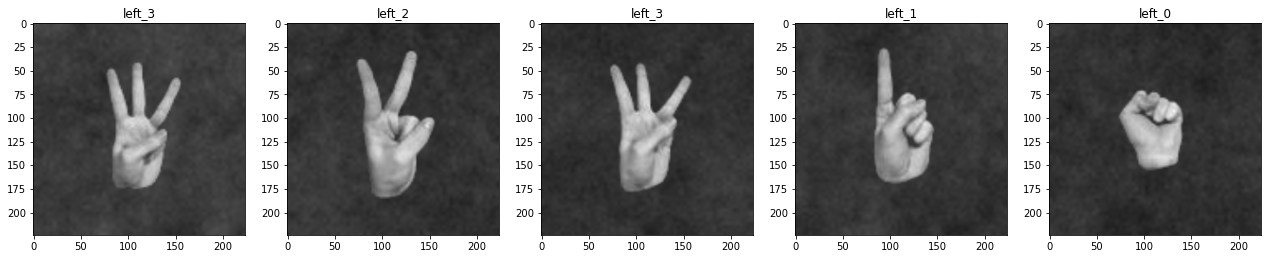

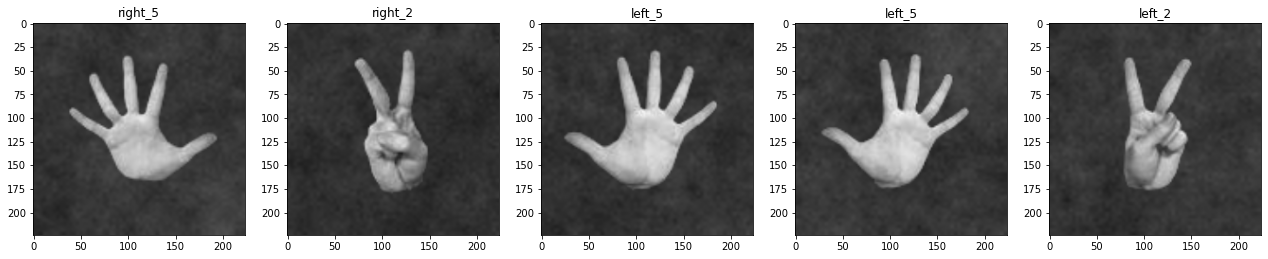

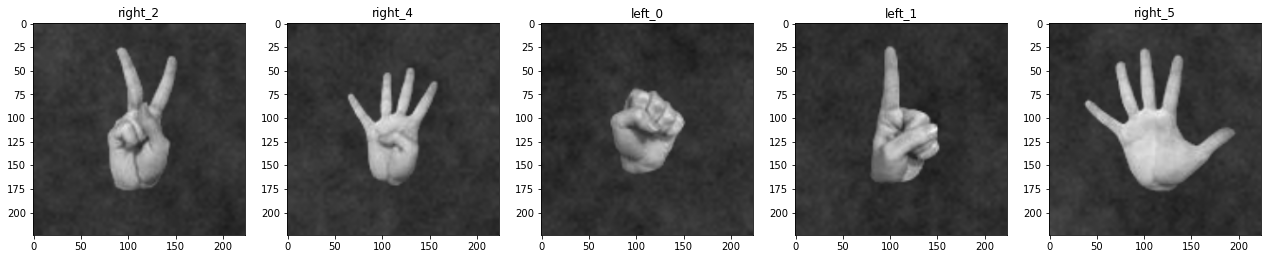

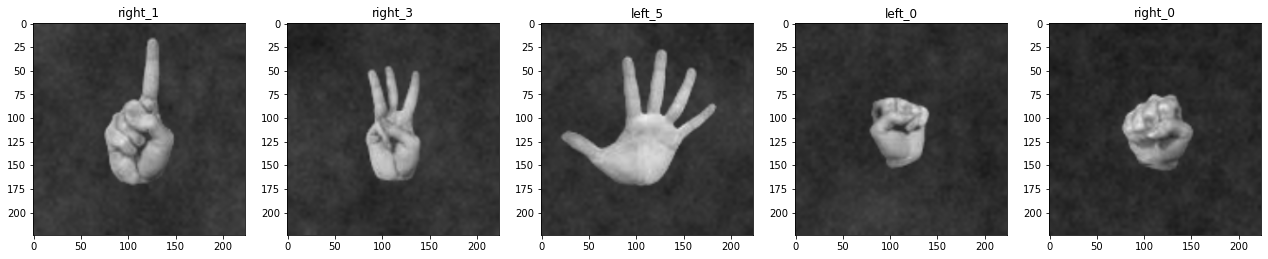

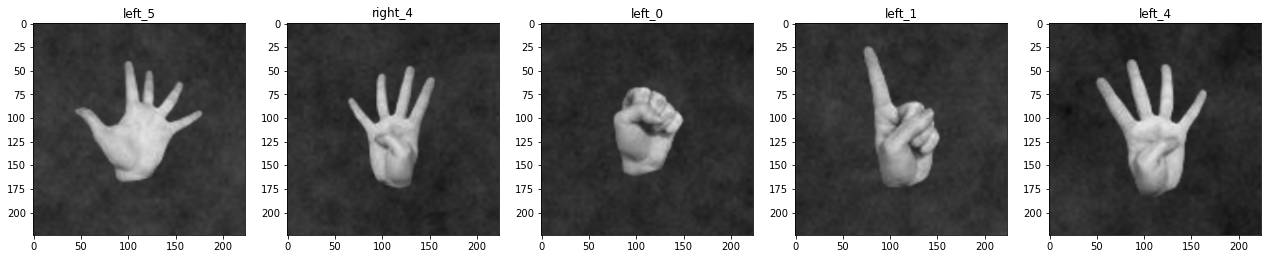

loss : 0.00908,    acc : 0.99309


In [106]:
import random
import matplotlib.pyplot as plt

with torch.no_grad() :
    val_loss = 0
    val_acc = 0
    for i, (x, y) in enumerate(test_data) :
        y = y.reshape(-1)
        
        predict = model(x)
        loss = criterion(predict, y)

        val_loss += loss / len(test_data)
        correct_prediction = torch.argmax(predict, 1) == y # [True, Flase, True ...]
        correct_prediction = correct_prediction.sum()
        val_acc += correct_prediction
          
        #Visualize 5 items for 5 batchs
        if i < 5 :
            r = random.sample(range(0, len(x)), 5)
            fig = plt.figure(figsize = (22, 22))
            result_list = ['left_0', 'left_1', 'left_2', 'left_3', 'left_4', 'left_5', 
                          'right_0', 'right_1', 'right_2', 'right_3', 'right_4', 'right_5']
            for i in range(5) :
                label = predict[r[i]]
                label = torch.argmax(label).item()

                img = x[r[i]].to('cpu').numpy()
                img = np.transpose(img, (1,2,0))

                subplot = fig.add_subplot(1, 5, i+1)
                subplot.set_title(result_list[label])
                subplot.imshow(img, cmap=plt.cm.gray_r)
            plt.show()
    
    val_acc = val_acc.item() / (32 * len(test_data))
    print('loss : {:.5f},    acc : {:.5f}'.format(val_loss, val_acc))